In [31]:
import os
import time
import random as rn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19 #, MobileNetV2, ResNet152V2, EfficientNetV2M, InceptionResNetV2, InceptionV3, EfficientNetV2B2, EfficientNetB5, ResNet50V2, EfficientNetB0 The best model was VGG 19 so I commented out other models
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


In [2]:
seed_number = 42 # The Answer to the Ultimate Question of Life, the Universe, and Everything is 42

# Set seed for NumPy
np.random.seed(seed_number)

# Set seed for TensorFlow
tf.random.set_seed(seed_number)

# Set seed for Python's built-in random module (used by Keras data generators)
rn.seed(seed_number)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
classes = {'no_tumor':0, 'glioma_tumor':1, 'meningioma_tumor':2, 'pituitary_tumor':3}
#classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

### Reading images from google drive

In [ ]:
X = []
y = []
img_size = 192

for cls in classes:
    pth = "/content/drive/MyDrive/NeuroDetect/Brain-Tumor-Classification-DataSet/Training/"+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 1)
        img = cv2.resize(img, (img_size,img_size))
        X.append(img)
        y.append(classes[cls])


for cls in classes:
    pth = "/content/drive/MyDrive/NeuroDetect/Brain-Tumor-Classification-DataSet/Testing/"+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 1)
        img = cv2.resize(img, (img_size,img_size))
        X.append(img)
        y.append(classes[cls])

### We observe a class imbalance issue, where the 'no tumor' class comprises only half of the samples compared to the other classes.

In [ ]:
pd.Series(y).value_counts()

2    937
1    926
3    901
0    500
dtype: int64

In [ ]:
X = np.array(X)
y = np.array(y)

### Convert class labels to numerical indices for both training and testing sets

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### Spliting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.15)

In [ ]:
X_train.shape, X_test.shape

((2774, 192, 192, 3), (490, 192, 192, 3))

## Some Visualizations

(-0.5, 191.5, 191.5, -0.5)

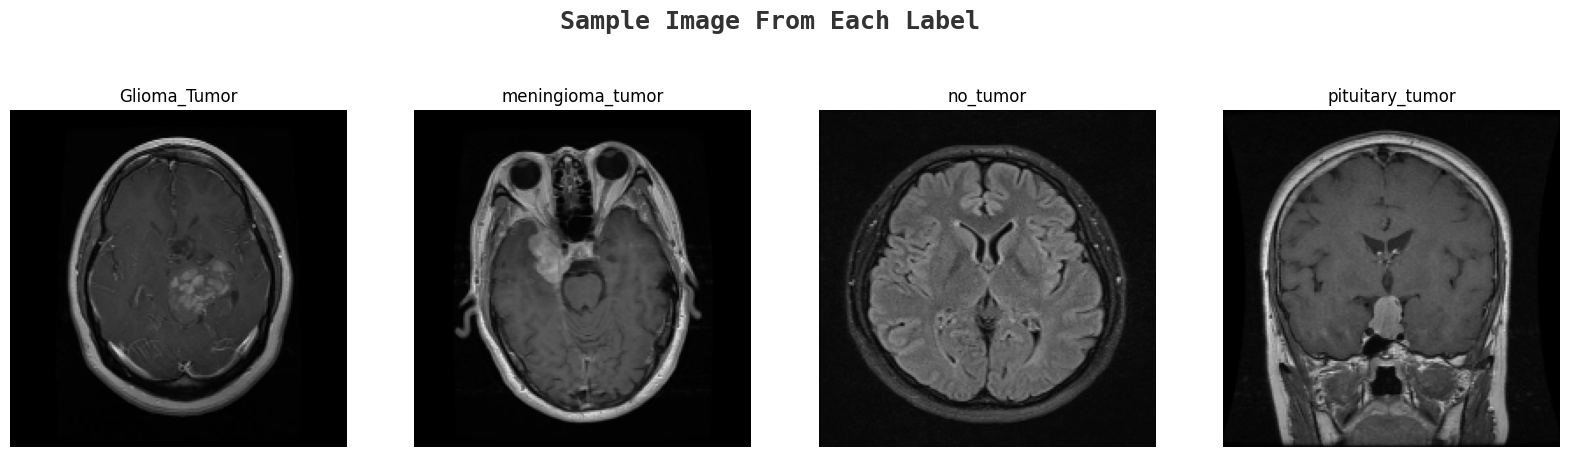

In [ ]:
# @title
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)

glioma_tumor = cv2.imread("/content/drive/MyDrive/NeuroDetect/Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (1).jpg", 1)
glioma_tumor = cv2.resize(glioma_tumor,(img_size, img_size))
meningioma_tumor = cv2.imread("/content/drive/MyDrive/NeuroDetect/Brain-Tumor-Classification-DataSet/Training/meningioma_tumor/m (104).jpg", 1)
meningioma_tumor = cv2.resize(meningioma_tumor,(img_size, img_size))
no_tumor = cv2.imread("/content/drive/MyDrive/NeuroDetect/Brain-Tumor-Classification-DataSet/Training/no_tumor/7.jpg", 1)
no_tumor = cv2.resize(no_tumor, (img_size, img_size))
pituitary_tumor = cv2.imread("/content/drive/MyDrive/NeuroDetect/Brain-Tumor-Classification-DataSet/Training/pituitary_tumor/p (100).jpg", 1)
pituitary_tumor = cv2.resize(pituitary_tumor, (img_size, img_size))

ax[0].imshow(glioma_tumor)
ax[0].set_title("Glioma_Tumor")
ax[0].axis('off')

ax[1].imshow(meningioma_tumor)
ax[1].set_title("meningioma_tumor")
ax[1].axis('off')

ax[2].imshow(no_tumor)
ax[2].set_title("no_tumor")
ax[2].axis('off')

ax[3].imshow(pituitary_tumor)
ax[3].set_title("pituitary_tumor")
ax[3].axis('off')

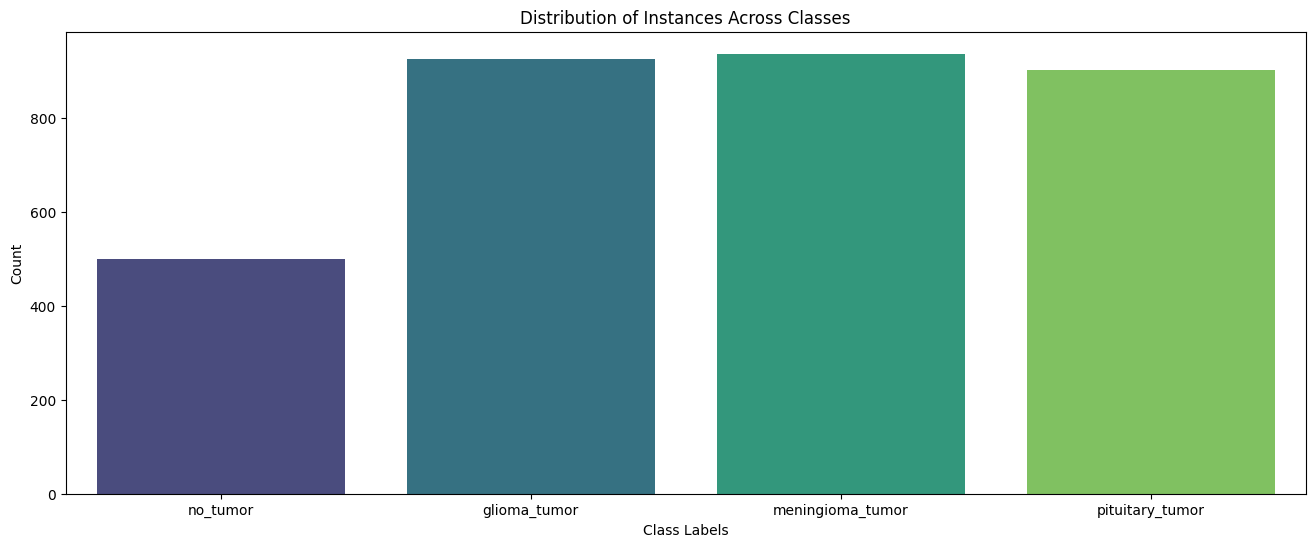

In [ ]:
# @title
plt.figure(figsize=(16, 6))
sns.countplot(x=y, palette='viridis')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Instances Across Classes')

class_names = list(classes.keys())

plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)

plt.show()


### Generating data and handling class imbalance

In [ ]:
batch_size = 32
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))


## Creating the model

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


Model_name = "VGG"
Version = "19"
Image_Size = f"{img_size}x{img_size}"

NAME = f"NeuroDetect-{Image_Size}-{Model_name+Version}-{int(time.time())}"

# Freezing layers
for layer in base_model.layers:
  layer.trainable = False

# Adding layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(len(classes), activation='softmax')(x)



# Final models
model = Model(inputs=base_model.input, outputs=predictions)

initial_lr = 0.01
epochs = 25
decay_rate = 0.001 / epochs
optimizer = Adam(learning_rate=initial_lr)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, restore_best_weights = True, min_lr=decay_rate, min_delta = 0.001)
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=0, write_graph=True, write_images=False)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=epochs,
    class_weight = class_weights,
    validation_data=(X_test, y_test),
    callbacks=[tensorboard, model_checkpoint, lr_scheduler],
    verbose = 2
)

Epoch 1/25
87/87 - 44s - loss: 1.4860 - accuracy: 0.6020 - val_loss: 1.3565 - val_accuracy: 0.4510 - lr: 0.0100 - 44s/epoch - 506ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/25
87/87 - 29s - loss: 0.9862 - accuracy: 0.6691 - val_loss: 0.9102 - val_accuracy: 0.6776 - lr: 0.0100 - 29s/epoch - 334ms/step
Epoch 3/25
87/87 - 28s - loss: 0.8674 - accuracy: 0.7008 - val_loss: 0.8389 - val_accuracy: 0.6490 - lr: 0.0100 - 28s/epoch - 319ms/step
Epoch 4/25
87/87 - 29s - loss: 0.8276 - accuracy: 0.7033 - val_loss: 0.6407 - val_accuracy: 0.7755 - lr: 0.0100 - 29s/epoch - 332ms/step
Epoch 5/25
87/87 - 32s - loss: 0.7367 - accuracy: 0.7257 - val_loss: 0.5559 - val_accuracy: 0.8224 - lr: 0.0100 - 32s/epoch - 372ms/step
Epoch 6/25
87/87 - 28s - loss: 0.6767 - accuracy: 0.7322 - val_loss: 0.5479 - val_accuracy: 0.7878 - lr: 0.0100 - 28s/epoch - 319ms/step
Epoch 7/25
87/87 - 28s - loss: 0.6950 - accuracy: 0.7368 - val_loss: 0.4918 - val_accuracy: 0.8143 - lr: 0.0100 - 28s/epoch - 324ms/step
Epoch 8/25
87/87 - 31s - loss: 0.6465 - accuracy: 0.7509 - val_loss: 0.4652 - val_accuracy: 0.8286 - lr: 0.0100 - 31s/epoch - 356ms/step
Epoch 9/25
87/87 - 28s - loss: 0.5801 - a

## Tracking

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

## Observing the best result

16/16 [==============================] - 1s 86ms/step


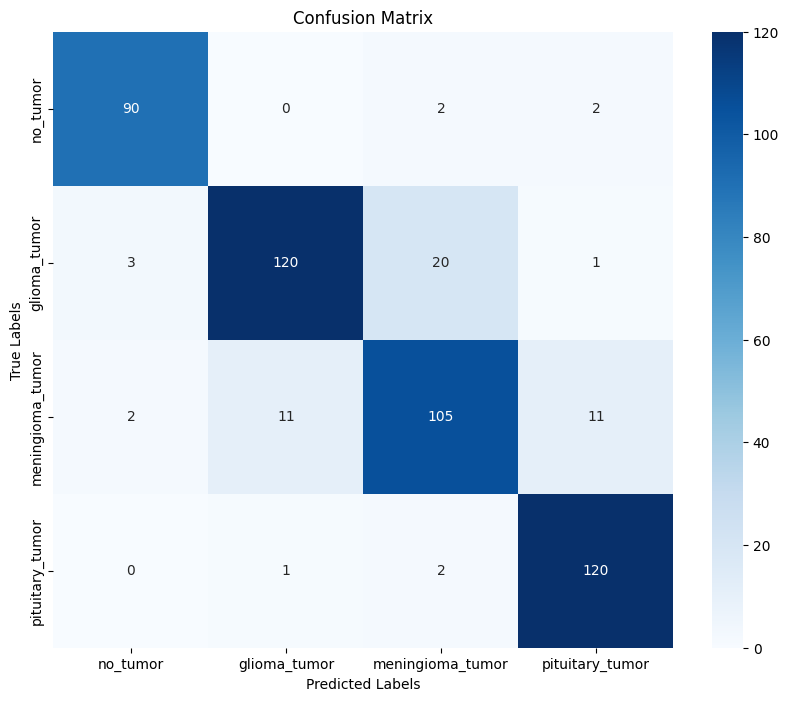

In [ ]:

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


class_names = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        94
           1       0.91      0.83      0.87       144
           2       0.81      0.81      0.81       129
           3       0.90      0.98      0.93       123

    accuracy                           0.89       490
   macro avg       0.89      0.90      0.89       490
weighted avg       0.89      0.89      0.89       490



### In medical imaging, accuracy may not be the most crucial metric. Minimizing false negatives takes precedence. Here, we observe a 95% precision for the 'no tumor' class, with a total of 5 false negatives.

Saving the model

In [ ]:
model.save("model.h5")

# The extra binary classification model


### Create a dataset with 600 images, evenly distributed between 'no_tumor' and 'tumor' classes, considering their distinctiveness.
### For 'no_tumor,' select 300 images. For 'tumor' classes, adjust the number based on their dissimilarity with 'no_tumor.'
### For instance, 'pituitary_tumor' is less similar, so we choose 60 images, while other 'tumor' classes have 120 images each.

In [5]:
img_size = 150
X = []
y = []

for cls in classes:
    pth = "/content/drive/MyDrive/NeuroDetect/Brain-Tumor-Classification-DataSet/Training/" + cls
    num_images = 300 if cls == "no_tumor" else (60 if cls == "pituitary_tumor" else 120)

    # List all files in the directory
    files = os.listdir(pth)

    # Sample the required number of images
    sampled_files = rn.sample(files, num_images)

    # Iterate over the sampled files
    for j in sampled_files:
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (img_size, img_size))
        X.append(img)
        y.append("no_tumor" if cls == "no_tumor" else "tumor")

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X, y, random_state=42, shuffle=True, test_size=0.2
)


We don't have class imbalance issue here

In [6]:
pd.Series(y_train_binary).value_counts()

tumor       242
no_tumor    238
dtype: int64

## Again some visualizations

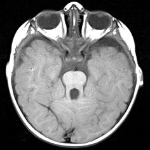

'no_tumor'

In [ ]:
from google.colab.patches import cv2_imshow
g = 12
cv2_imshow(X_train_binary[g])
y_train_binary[g]

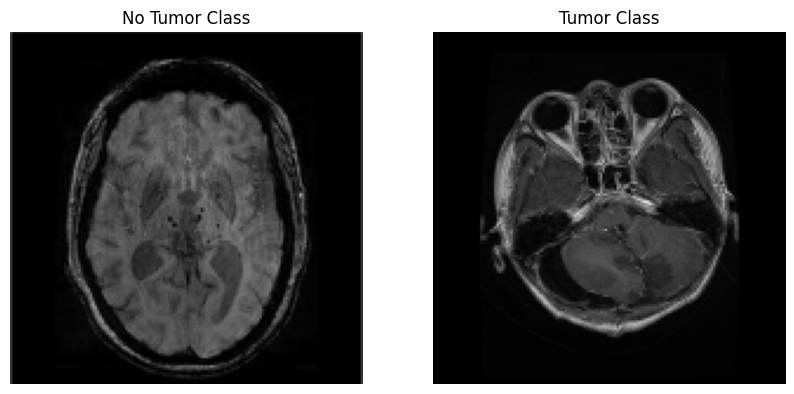

In [11]:
# @title
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].set_title('No Tumor Class')
axes[1].set_title('Tumor Class')

# Choose random samples for each class
no_tumor_samples = rn.sample(
    [i for i, label in enumerate(y_train_binary) if label == 'no_tumor'],
    5  # Choose the number of samples to display
)

tumor_samples = rn.sample(
    [i for i, label in enumerate(y_train_binary) if label == 'tumor'],
    5  # Choose the number of samples to display
)

# Plot images for 'no_tumor' class
for i, idx in enumerate(no_tumor_samples):
    axes[0].imshow(X_train_binary[idx])
    axes[0].axis('off')
    if i == 0:
        axes[0].set_title('No Tumor Class')

# Plot images for 'tumor' class
for i, idx in enumerate(tumor_samples):
    axes[1].imshow(X_train_binary[idx])
    axes[1].axis('off')
    if i == 0:
        axes[1].set_title('Tumor Class')

plt.show()

### Generating data:

In [18]:
batch_size = 32
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_binary_arr)

## Creating the model

In [22]:
import random

X_train_binary_arr = np.array(X_train_binary)
X_test_binary_arr = np.array(X_test_binary)
y_train_binary_arr = np.array(y_train_binary)
y_test_binary_arr = np.array(y_test_binary)
# Standardize the features (important for SVM)
# Encode labels to numerical values (0 for 'no_tumor', 1 for 'tumor')
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_binary_arr)
y_test_encoded = label_encoder.transform(y_test_binary_arr)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train_binary_arr / 255.0
X_test_normalized = X_test_binary_arr / 255.0

# Build the Convolutional Neural Network (CNN) model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train_normalized, y_train_encoded, batch_size=32), validation_data=(X_test_normalized, y_test_encoded), epochs=15)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_normalized, y_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/15
15/15 [==============================] - 6s 295ms/step - loss: 0.6977 - accuracy: 0.5917 - val_loss: 0.6187 - val_accuracy: 0.6583
Epoch 2/15
15/15 [==============================] - 2s 163ms/step - loss: 0.6148 - accuracy: 0.6729 - val_loss: 0.5716 - val_accuracy: 0.6917
Epoch 3/15
15/15 [==============================] - 3s 167ms/step - loss: 0.4807 - accuracy: 0.7688 - val_loss: 0.3904 - val_accuracy: 0.8583
Epoch 4/15
15/15 [==============================] - 4s 283ms/step - loss: 0.4530 - accuracy: 0.7958 - val_loss: 0.4017 - val_accuracy: 0.8167
Epoch 5/15
15/15 [==============================] - 3s 168ms/step - loss: 0.3613 - accuracy: 0.8667 - val_loss: 0.3354 - val_accuracy: 0.8833
Epoch 6/15
15/15 [==============================] - 3s 169ms/step - loss: 0.3630 - accuracy: 0.8438 - val_loss: 0.5285 - val_accuracy: 0.7833
Epoch 7/15
15/15 [==============================] - 3s 168ms/step - loss: 0.3997 - accuracy: 0.8479 - val_loss: 0.3341 - val_accuracy: 0.8833
Epoch 

## Observing the result

4/4 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


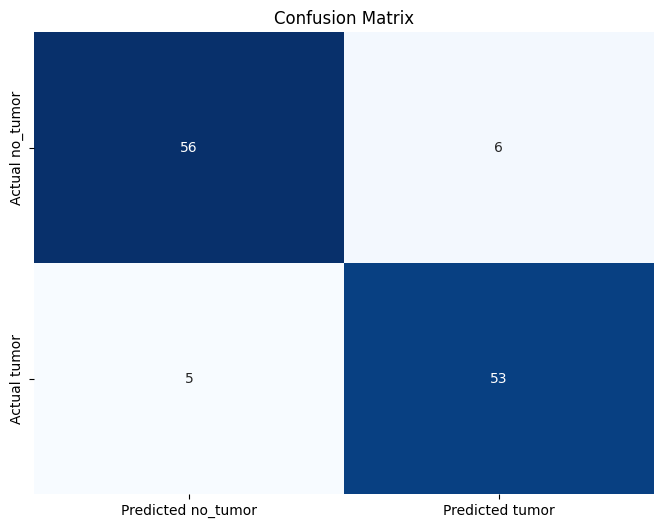

Classification Report:
               precision    recall  f1-score   support

    no_tumor       0.92      0.90      0.91        62
       tumor       0.90      0.91      0.91        58

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120



In [28]:
y_pred_probs = model.predict(X_test_normalized)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Reverse label encoding for y_test_encoded
y_test_original = label_encoder.inverse_transform(y_test_encoded)

# Reverse label encoding for y_pred
y_pred_original = label_encoder.inverse_transform(y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original)

# Plot Confusion Matrix with Count Values
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Predicted no_tumor', 'Predicted tumor'])
plt.yticks([0.5, 1.5], ['Actual no_tumor', 'Actual tumor'])
plt.show()

# Classification Report
class_report = classification_report(y_test_original, y_pred_original)
print("Classification Report:\n", class_report)

Saving the model

In [30]:
model.save("model_binary.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
